In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
''' install the desired pytorch version '''
!pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1 MB 1.8 kB/s 
     |████████████████████████████████| 8.8 MB 5.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.2.0+cu92 which is incompatible.


In [4]:
''' importing the neccessary libraries '''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt

from collections import OrderedDict

import pdb
from math import sqrt, ceil

from torch.autograd import Variable

from PIL import Image

from functools import partial
import sys

In [5]:
''' load the CIFAR - 10 '''
''' taken from Pytorch Docs '''
## transforms are used to convert the data to tensors for easy use with CNN models
transform = transforms.Compose([
    transforms.Resize(size=(32, 32)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])


batch_size = 32


# downloading the training data through Pytorch API
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#note num_workers attribute tells the number of workers(threads) that performs the task
#other attributes are pretty self-explanatory
#loading the training data 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# downloading the test data through Pytorch API
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#loading the test data 
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170500096it [00:04, 38616118.54it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
#now the main part ,the code for the actual model
# We use the VGG16 Architecture (Zisserman et al)
class SMAI(nn.Module):
  def __init__(self):
    #not sure exactly how this works.Something to do with inheritance,
    super(SMAI , self).__init__()

    #we use default values of stride = 1
    #and padding = 0
    #our input is (3,32,32) C,H,W
    #set out_channel as 64,so we get 32 kernels in the layer
    # therefore output dimension are (64,32,32) C,H,W
    #self.conv1 = nn.Conv2d(in_channels = 1,out_channels = 32 , kernel_size = 3)


    #we want two linear layers
    #first hidden layer
    #self.d1 = nn.Linear(26*26*32,128)
    
    #ouput layer
    # 10 is the output class
    #self.d2 = nn.Linear(128,10)

    #the sequential is a container
    #takes an input 
    #chains the input - output to the next layer
    #returns the final output
    #input BATCH_SIZE * 1 * 28 * 28 for MNIST
    #commenting out some of the maxpooling Blocks to make sure kernel spatial dimension reduces to 7*7 and not below
    self.features = nn.Sequential(
        
        
        
        
     

      nn.Conv2d(3,16,3,padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, stride = 2, return_indices = True) ,

      #output 32,16,16,16

    
      nn.Conv2d(16,32,3,padding = 1),
      nn.ReLU(),
      nn.MaxPool2d(2, stride = 2, return_indices = True) ,

     #output 32,32,8,8

    
      nn.Conv2d(32,32,3,padding = 1),
      nn.ReLU()
    
    #output 32,32,8,8

    



        
    )

    self.classifier = nn.Sequential(

        
        nn.Linear(2048,128),
        nn.Dropout(p=0.2),

    # Linear layer with 10 output features
        nn.Linear(128,10)

    )

    self.feature_maps = OrderedDict() #used to store all feature maps
    self.max_pooling_locations = OrderedDict() #used to store the location of the values from max pools
    self.Convolution_layers_indices = [0,3,6]
    self.Relu_layers_indices = [1,4,7]
    self.pooling_layers_indices = [2,5]
    
  
  #a function to initialise with a pretrained model
  #has to have the same architecture as the one define above
  #must be compatible with above defined structure of features and classifier
  def initialise_weights(self,model):
    #copy the parameter values for features
    for index,layer in enumerate(model.features):
      #only relevant for learnable parameters,not for Pooling,Relu etc
      if isinstance(layer,nn.conv2d):
        self.features[index].weight.data = layer.weight.data
        self.features[index].bias.data = layer.bias.data
    #copy the parameter values for classifier
    for index,layer in enumerate(model.classifier):
      #only relevant for FC Linear parameters
      if isinstance(layer,nn.Linear):
        self.classifier[index].weight.data = layer.weight.data
        self.classifier[index].bias.data = layer.bias.data

  #function for forward propagation
  def forward(self,x):
    #neccessary for storing the max pool location for inverse pooling
    for index,layer in enumerate(self.features):
      if isinstance(layer,nn.MaxPool2d):
        x, locs = layer(x)
      else:
        x = layer(x)
    #converts a (N,C,H,W) input to (N,C*H*W)
    x = x.view(x.size()[0],-1)
    output = self.classifier(x)
    output = torch.nn.functional.softmax(output,dim = 1)
    return output

#this is the twin Deconvnet of the above VGG16 called Roy Net
class SMAI_Deconv(nn.Module) :
  def __init__(self):
        super(SMAI_Deconv, self).__init__()
        self.features = nn.Sequential(
          

          nn.ReLU(),
          nn.ConvTranspose2d(32, 32, 3, padding = 1),

          nn.MaxUnpool2d(2, stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(32, 16, 3, padding = 1),

          nn.MaxUnpool2d(2, stride = 2),
          nn.ReLU(),
          nn.ConvTranspose2d(16, 3, 3, padding = 1),
          


        )
        
        #this maps the indices of the layer of in conv net architecture with the deconvnet architecture
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_index_mapping = {0:7 , 3:4 , 6:1}
        #this maps the bias of the conv layer with the deconv layer.For some reason this does not 
        #perfectly allign with above transformation because the first backward layer is randomly set
        #{forward_ind : backward_ind}
        self.conv_deconv_layer_bias_index_mapping = {0:4,3:1}

        #this maps the forward and backward relu layer
        #{forward_ind : backward_ind}
        self.relu_relu_layer_index_mapping = {1:6 , 4:3 , 7:0}

        #this maps the forward maxpool layer index to the backward maxunpool netword
        #{backward_ind : forward}
        self.unmaxpool_maxpool_layer_index_mapping = {5:2, 2:5}

  #this updates the parameters of the deconv model from the passed parameter which is the forward model
  def update_weights(self, model):

    #update the paramters
    for index,layer in enumerate(model.features):
      if isinstance(layer,nn.Conv2d):
        self.features[self.conv_deconv_layer_index_mapping[index]].weight.data = layer.weight.data
        if index in self.conv_deconv_layer_bias_index_mapping:
          self.features[self.conv_deconv_layer_bias_index_mapping[index]].bias.data = layer.bias.data
          #print("do")
  #forward pass to obtain the inverse image
  #pool locs is useful for maxunpooling
  #layer is the index of the layer from which x is passed(I think)
  #I am not too sure
  #The input layer should be a RELU or CONV
  #Not sure why Maxpooling layer not allowed
  def forward(self, x , layer  , pool_locs):
    #print("Forward")
    if layer in self.conv_deconv_layer_index_mapping:
      start_index = self.conv_deconv_layer_index_mapping[layer]
    elif layer in self.relu_relu_layer_index_mapping:
      start_index = self.relu_relu_layer_index_mapping[layer]
    else:
      print("The given layer is not RELU or Conv,exiting")
      #sys.exit(0)
    
    for index in range(start_index,len(self.features)):
      if isinstance(self.features[index] , nn.MaxUnpool2d):
        print("Unpool")
        x = self.features[index](x,pool_locs[self.unmaxpool_maxpool_layer_index_mapping[index]])
      else:
        if isinstance(self.features[index],nn.ConvTranspose2d):
          print("Transpose")
        if isinstance(self.features[index],nn.ReLU):
          print("RElu")
        x = self.features[index](x)
    return x

    







In [7]:
#Function to visualize a feature map in a grid
#feature map is the shape (C,W,H,N)
#this part is I dont understand that well
#utility function for visualization
def visualize_feature_map(feature_map):
  (C,W,H,N) = feature_map.shape
  cnt = int(ceil(sqrt(C)))
  G = np.ones((cnt*H + cnt,cnt*W + cnt,N),feature_map.dtype)#the extra cnt is for black colored spacing
  G *= np.min(feature_map)

  n = 0
  for row in range(cnt):
    for col in range(cnt):
      if n < C:
        #additional cnt for spacing
        G[row*H + row : (row + 1)*H + row, col*W + col : (col + 1)*W + col,:] = feature_map[n,:,:,:]
        n += 1

  #Normalize G
  G = (G - G.min())/(G.max() - G.min())
  return G


#function to visualize a layer represented by a grid
#again do not understand this part much
def visualize_layer(feature_layer_grid):
  plt.clf() #clears figure
  plt.subplot(121)
  plt.imshow(feature_layer_grid[:,:,0],cmap = 'gray')


#transform a deconvolutional image to a normal one(Also normalize)
#input is the output of the deconvolated image
def transform_deconvolved_image(output) :
  d_img = output.data.numpy()[0].transpose(1,2,0) #gets it to (H,W,C) format
  d_img = (d_img - d_img.min())/(d_img.max() - d_img.min()) #normalize
  return d_img.astype(np.uint8)


#function to store all the feature maps and max_pooling locations
def store_all_feature_maps(model):
  #this is a function that is to be passed to another function
  #It will be called everytime forward is called on model
  def hook(module,input,output,key):
    if isinstance(module,nn.MaxPool2d):
      #remember the maxpool layer returns two values x,loc because return_indices is set to true
      model.feature_maps[key] = output[0] #stores the feature map to the ordereddict
      model.max_pooling_locations[key] = output[1] #stores the location
    else:
      model.feature_maps[key] = output
  for index,layer in enumerate(model._modules.get('features')):  
    #register forward hook makes the hook to be called whenever forward is called
    #partial allows hook to be called hook(module,input,output,key = index)
    layer.register_forward_hook(partial(hook,key = index))

  


In [8]:
Layers = [0,1,2,3,5]
Activation_Index = [3,10]
def unormalize(im):
  r = im[:,:,0] * 0.2023 + 0.4914
  g = im[:,:,1] * 0.1994 + 0.4822
  b = im[:,:,2] * 0.2010 + 0.4465
  new_im = np.zeros(im.shape)
  new_im[:,:,0] = r
  new_im[:,:,1] = g
  new_im[:,:,2] = b
  return new_im

EPOCH 1 VISUALIZATION


In [9]:
''' load the model'''
model = SMAI()
PATH = "./drive/MyDrive/Models/SMAI_MODEL_EPOCH_6.pth"


#print(checkpoint)
# original saved file with DataParallel
#state_dict = torch.load('myfile.pth.tar')
# create new OrderedDict that does not contain `module.`


# load params
model.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [10]:
next(model.parameters()).is_cuda # returns a boolean


False

In [11]:
model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
next(model.parameters()).is_cuda # returns a boolean


True

In [12]:
deconv = SMAI_Deconv()
deconv.update_weights(model)
deconv = deconv.to(device)
deconv.eval()


SMAI_Deconv(
  (features): Sequential(
    (0): ReLU()
    (1): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (3): ReLU()
    (4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
    (6): ReLU()
    (7): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [13]:
next(deconv.parameters()).is_cuda # returns a boolean


True

In [14]:
store_all_feature_maps(model)

In [15]:

layer = 0
epoch = 6
activation_index = 3
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)
'''


Calling Feature Visualization part for layer : 0 , epoch : 6 and activation_index : 3
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 45

'\nfile_path = "./drive/MyDrive/outputs/"\nact_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"\nact_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"\n\nprint("Saving Image")\nnp.save(act_name1,decov_final)\nnp.save(act_name2,src_image)\n'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Deconvoluted Image')

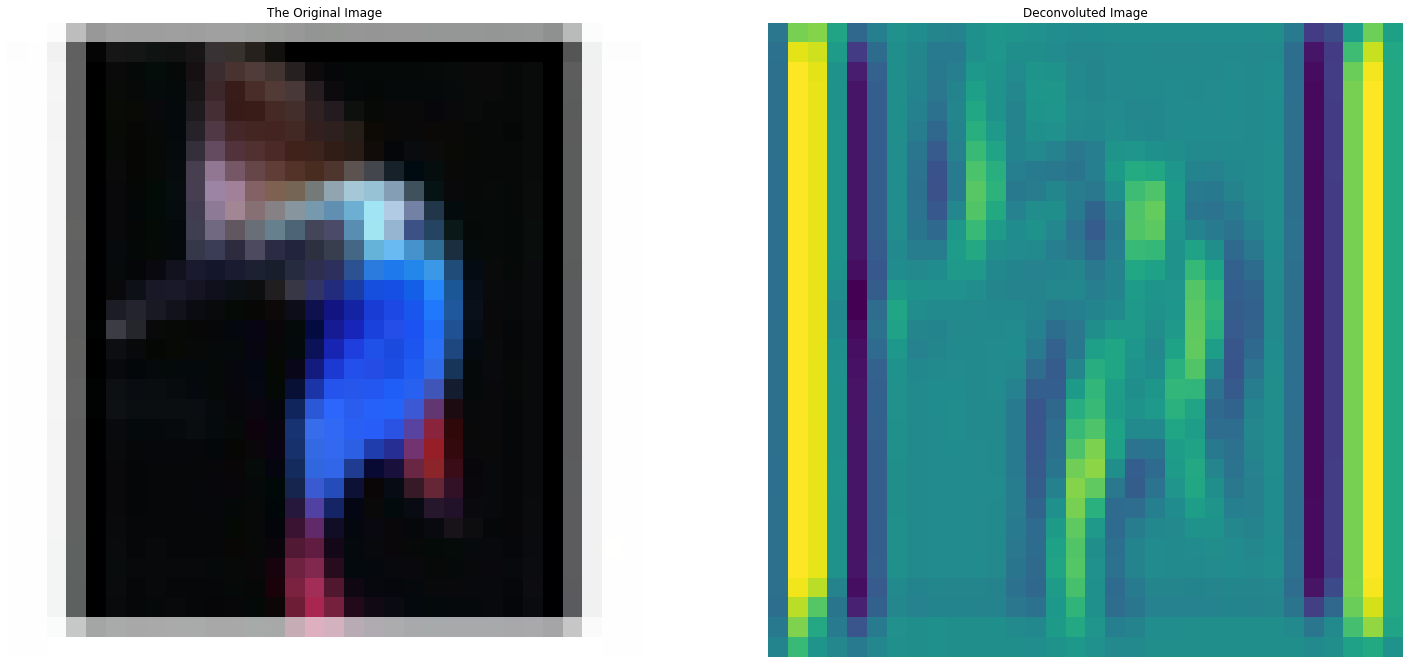

In [16]:
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

In [17]:
fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_0_index_3.jpg")

EPOCH : 1    LAYER : 0    ACTIVATION INDEX : 10

Calling Feature Visualization part for layer : 0 , epoch : 6 and activation_index : 10
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 4

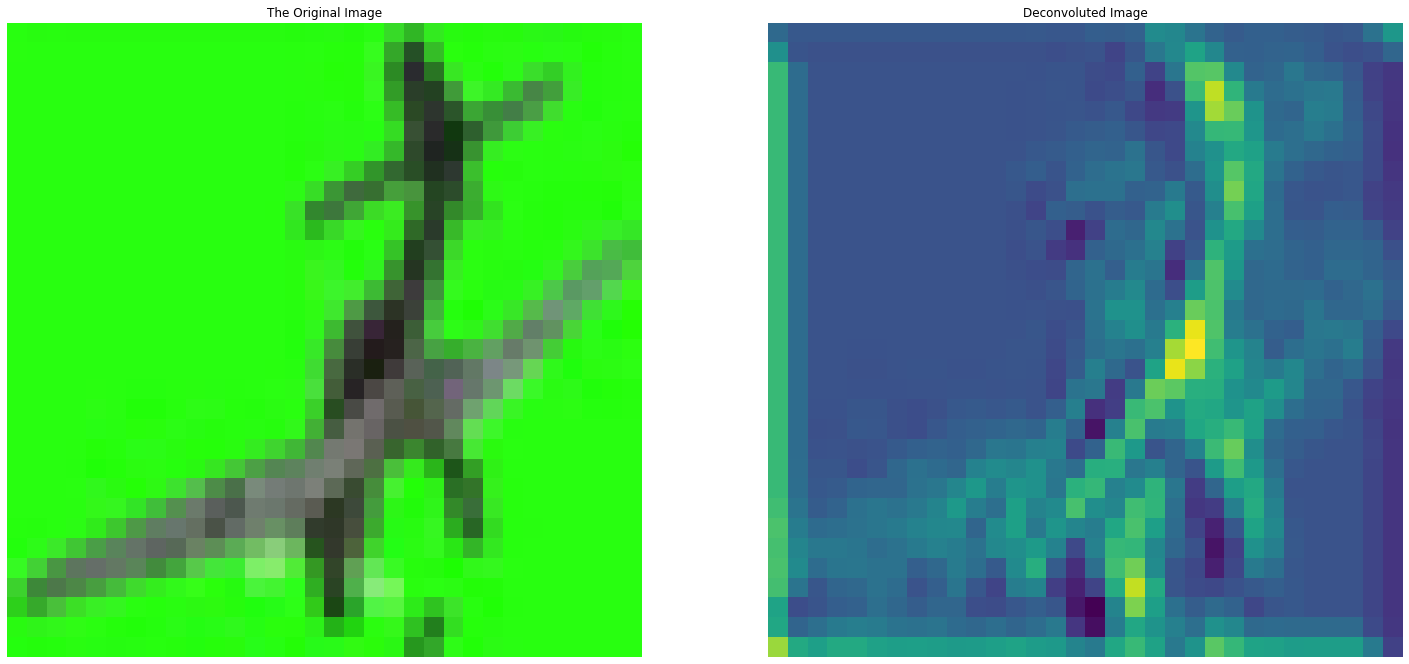

In [19]:

layer = 0
epoch = 6
activation_index = 10
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_0_index_10.jpg")


Calling Feature Visualization part for layer : 1 , epoch : 6 and activation_index : 3
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


progress : 44800 / 45000 = 0.9955555555555555
progress : 44832 / 45000 = 0.9962666666666666
progress : 44864 / 45000 = 0.9969777777777777
progress : 44896 / 45000 = 0.9976888888888888
progress : 44928 / 45000 = 0.9984
progress : 44960 / 45000 = 0.9991111111111111
progress : 44992 / 45000 = 0.9998222222222222
progress : 45024 / 45000 = 1.0005333333333333
RElu
Transpose


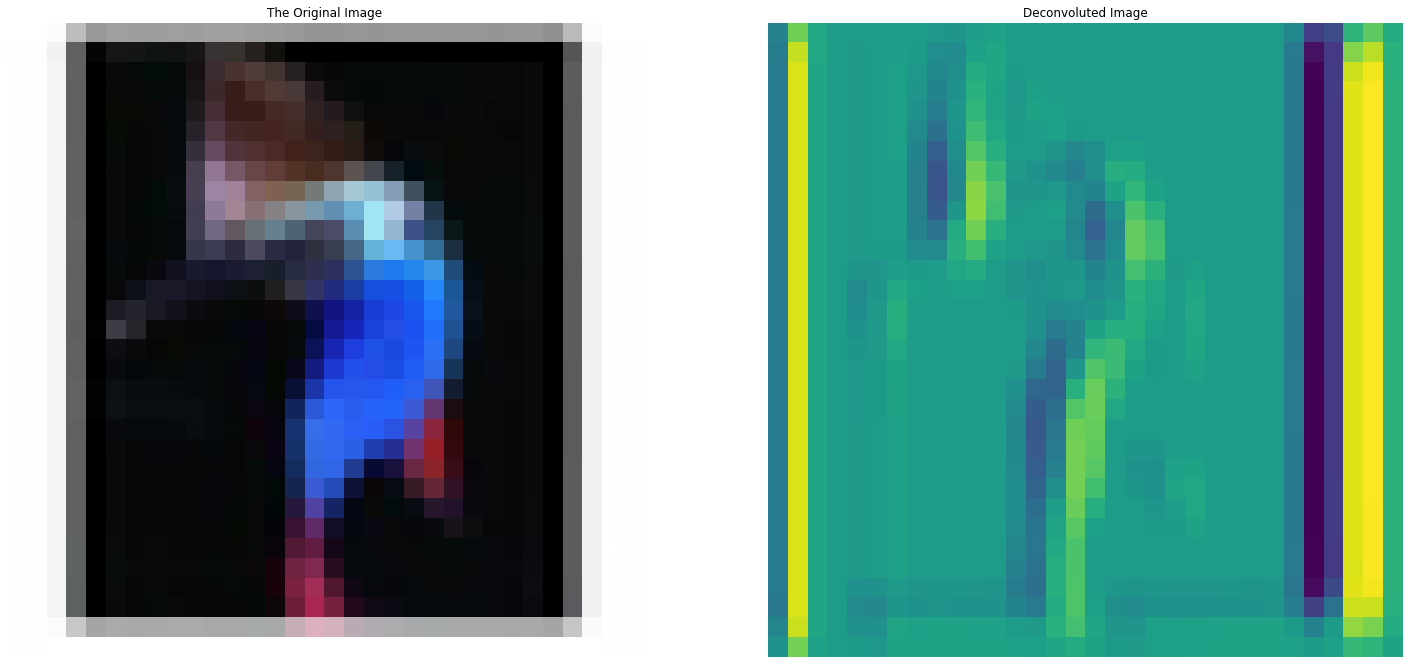

In [20]:

layer = 1
epoch = 6
activation_index = 3
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_1_index_3.jpg")


Calling Feature Visualization part for layer : 1 , epoch : 6 and activation_index : 10
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 4

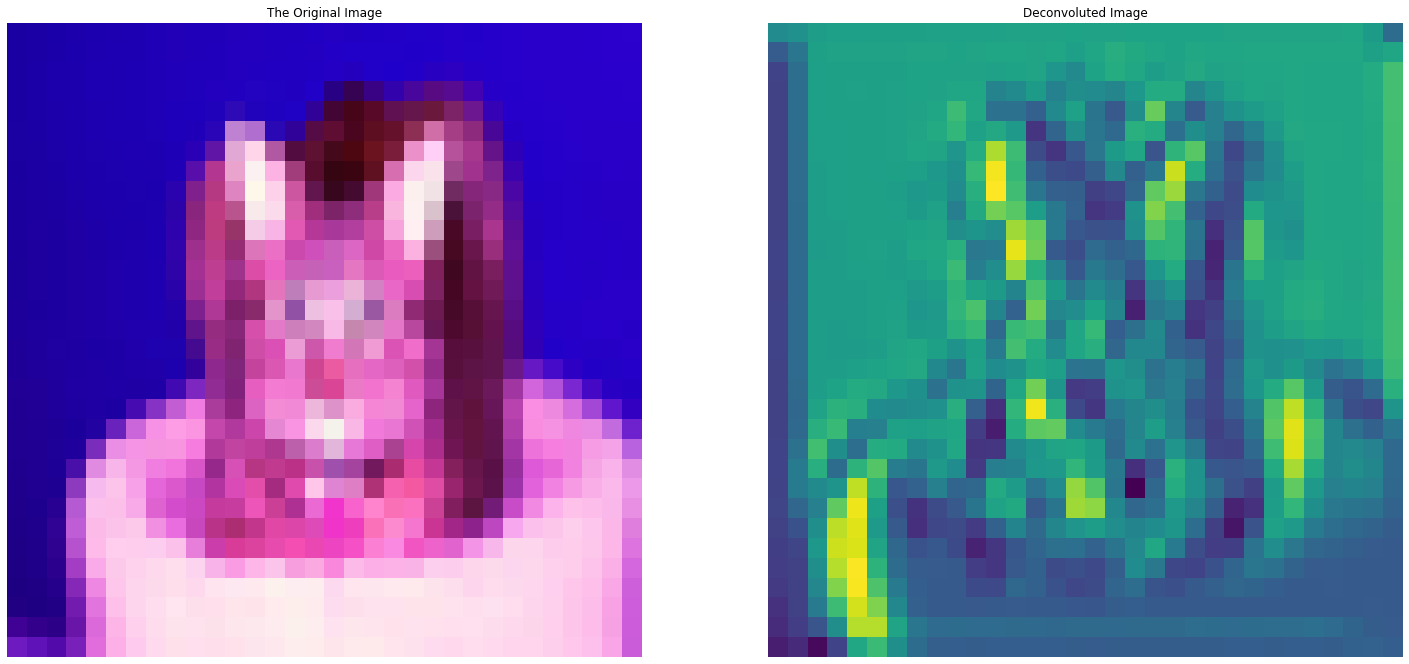

In [21]:

layer = 1
epoch = 6
activation_index = 10
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_1_index_10.jpg")


Calling Feature Visualization part for layer : 3 , epoch : 6 and activation_index : 3
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Transpose
Unpool
RElu
Transpose


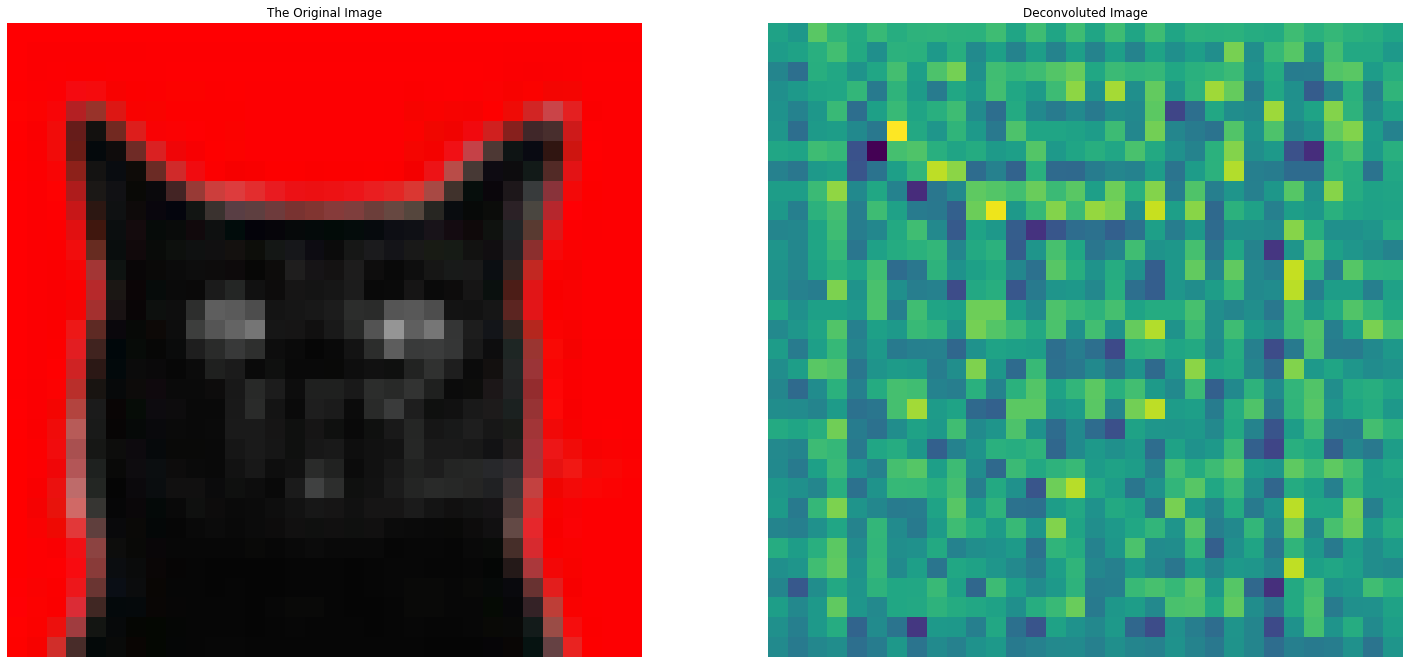

In [23]:

layer = 3
epoch = 6
activation_index = 3
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_3_index_3.jpg")


EPOCH 1
LAYER 2
ACTIVATION INDEX 10

Calling Feature Visualization part for layer : 3 , epoch : 6 and activation_index : 10
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 4

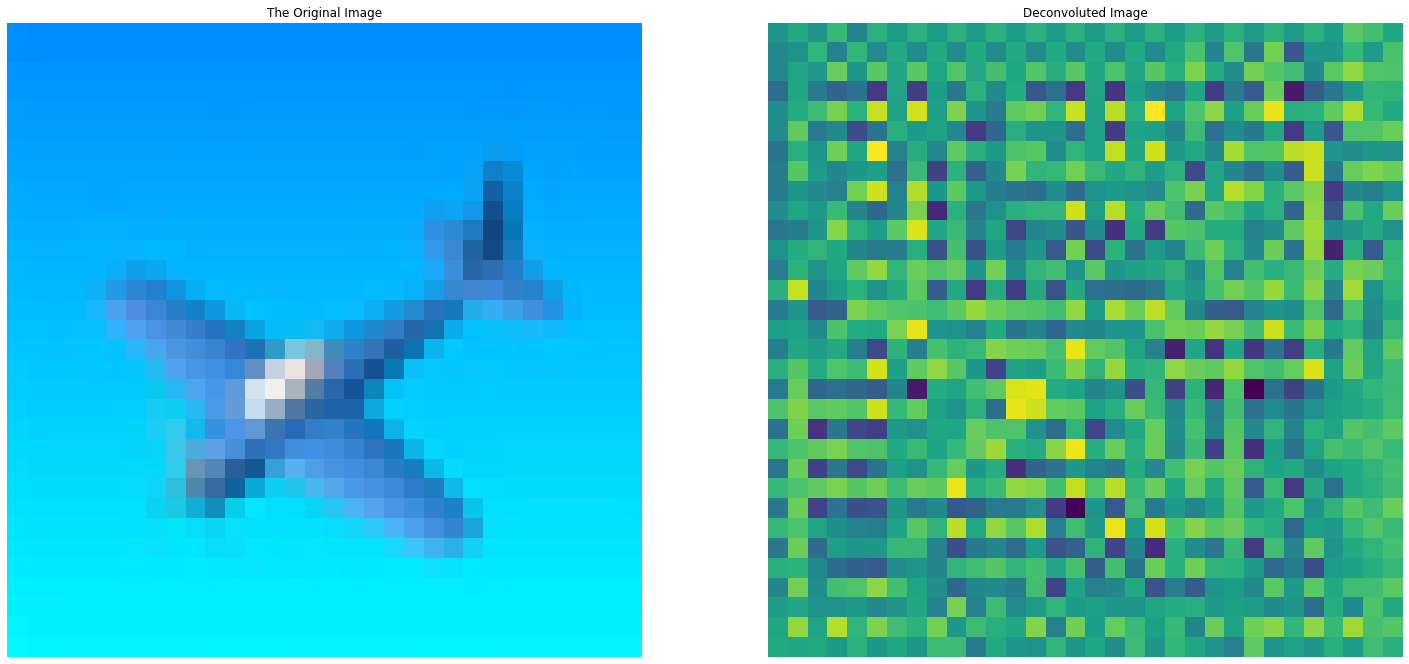

In [24]:

layer = 3
epoch = 6
activation_index = 10
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_3_index_10.jpg")


Calling Feature Visualization part for layer : 4 , epoch : 6 and activation_index : 3
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 45

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


RElu
Transpose
Unpool
RElu
Transpose


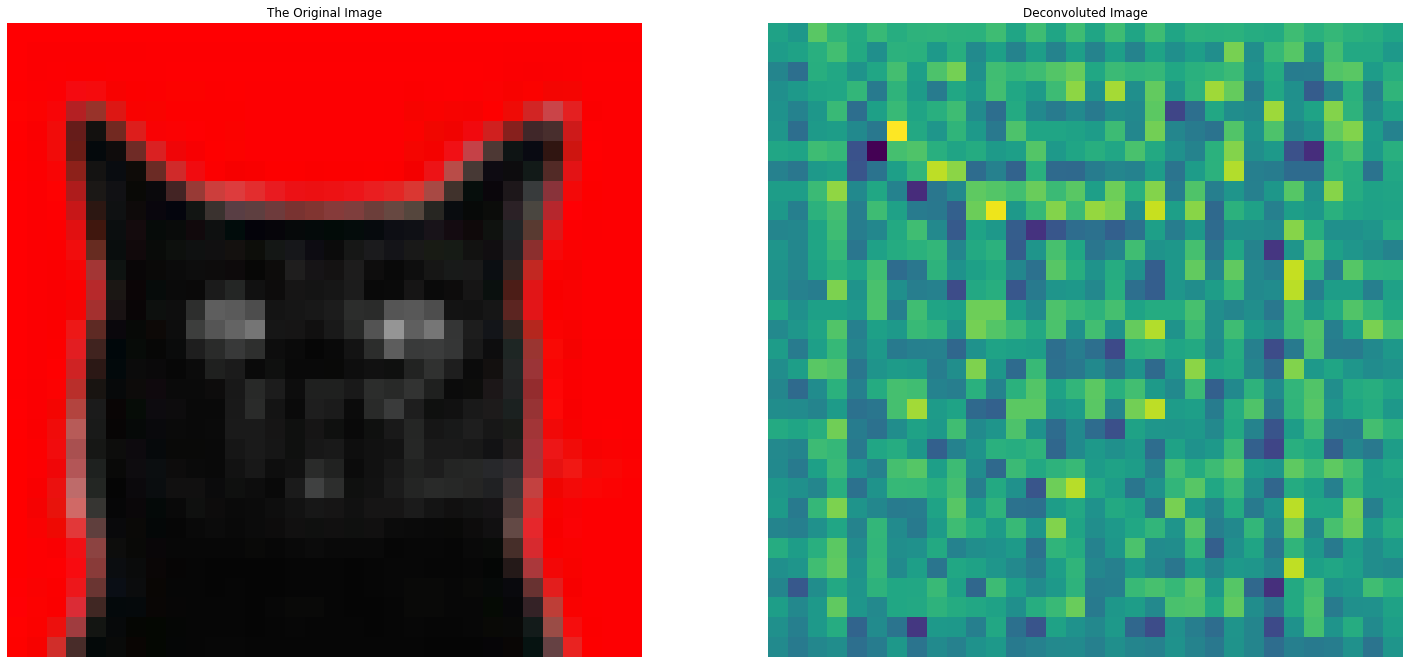

In [25]:

layer = 4
epoch = 6
activation_index = 3
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_4_index_3.jpg")


Calling Feature Visualization part for layer : 4 , epoch : 6 and activation_index : 10
progress : 32 / 45000 = 0.0007111111111111111
progress : 64 / 45000 = 0.0014222222222222223
progress : 96 / 45000 = 0.0021333333333333334
progress : 128 / 45000 = 0.0028444444444444446
progress : 160 / 45000 = 0.0035555555555555557
progress : 192 / 45000 = 0.004266666666666667
progress : 224 / 45000 = 0.004977777777777778
progress : 256 / 45000 = 0.005688888888888889
progress : 288 / 45000 = 0.0064
progress : 320 / 45000 = 0.0071111111111111115
progress : 352 / 45000 = 0.007822222222222222
progress : 384 / 45000 = 0.008533333333333334
progress : 416 / 45000 = 0.009244444444444444
progress : 448 / 45000 = 0.009955555555555556
progress : 480 / 45000 = 0.010666666666666666
progress : 512 / 45000 = 0.011377777777777778
progress : 544 / 45000 = 0.012088888888888889
progress : 576 / 45000 = 0.0128
progress : 608 / 45000 = 0.013511111111111111
progress : 640 / 45000 = 0.014222222222222223
progress : 672 / 4

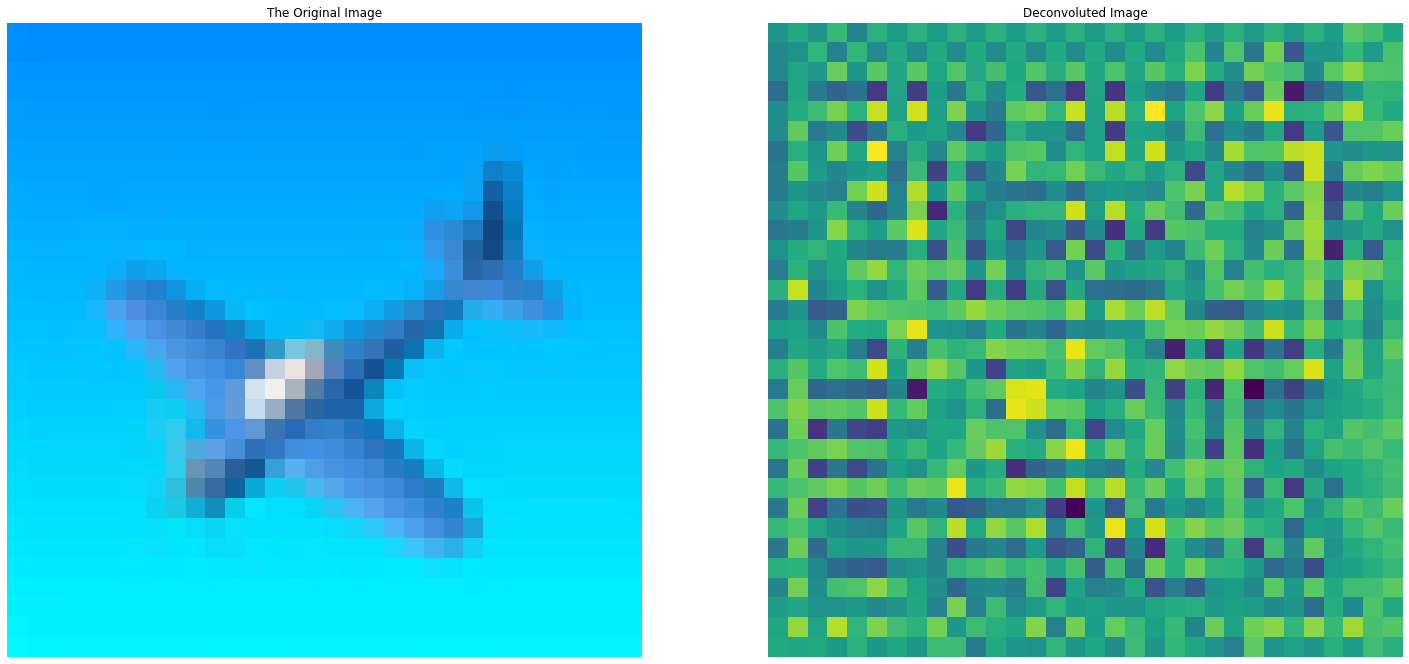

In [26]:

layer = 4
epoch = 6
activation_index = 10
print("Calling Feature Visualization part for layer : {0} , epoch : {1} and activation_index : {2}".format(layer,epoch,activation_index))

train_size = 45000
total_samples_to_be_used = train_size


samples_till_now = 0
batch_size = 32
highest_activate_image = np.zeros((32,32,3))
highest_activation = -np.inf
final_inp = None
deconv_image = np.zeros((32,32,3))
for i,(images,labels) in enumerate(trainloader):
  if samples_till_now >= total_samples_to_be_used :
    break
  else:
    samples_till_now += batch_size
  im = images.to(device)
  output = model(im)
  feature_map = model.feature_maps[layer].cpu().data.numpy().transpose(1, 2, 3, 0) # (N, C, H, W) -> (C, H, W, N)
  fmap = np.copy(feature_map)
  for j in range(batch_size):
    ft_mp = fmap[activation_index,:,:,j]
    activation = np.linalg.norm(ft_mp,2)
    if(activation >= highest_activation):
      highest_activation = activation
      src_image = np.transpose(images.cpu().numpy()[j],(1,2 ,0))
      src_image = unormalize(src_image)
      final_inp = im[j]
      final_inp = final_inp[None] # (N,C,H,W)
  #print("progress of computing the highest activation")
  print("progress : {0} / {1} = {2}".format(samples_till_now,total_samples_to_be_used,samples_till_now/total_samples_to_be_used))
final_inp = final_inp.to(device)
out = model(final_inp)
new_map = model.feature_maps[layer].clone() # (1,C,H,W)
if activation_index == 0:
  new_map[:,1:,:,:] = 0
else:
  new_map[:,:activation_index,:,:] = 0
  #print(new_map.shape)
  if activation_index < new_map.shape[1] - 1:
    new_map[:,activation_index + 1 :,:,:] = 0
#print("Deconvolution")
deconv_output = deconv(new_map , layer , model.max_pooling_locations)
r = deconv_output.cpu()[0][0][:][:]
decov_final = r.detach().numpy()

'''
file_path = "./drive/MyDrive/outputs/"
act_name1 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Deconv.npy"
act_name2 = file_path + "Activation_" + str(activation_index) + "_Layer_" + str(layer) + "_Epoch_" + str(epoch) + "_Src.npy"

print("Saving Image")
np.save(act_name1,decov_final)
np.save(act_name2,src_image)

'''
fig = plt.figure(figsize = (25,25))
fig.add_subplot(1,2,1)
plt.imshow(src_image)
plt.axis("off")
plt.title("The Original Image")
fig.add_subplot(1,2,2)
plt.imshow(decov_final)
plt.axis("off")
plt.title("Deconvoluted Image")

fig.savefig("./drive/MyDrive/outputs/SMAI_Epoch_6_Layer_4_index_10.jpg")
